In [1]:
import csv
import random

def load_data(filename, split, training_data = [], test_data = []):
    with open(filename, 'r') as file:
        rows = csv.reader(file)
        res = list(zip(*rows)) #transpose the matrix
        #print(res)
        data_set = list(map(list, zip(*res)))
        #print(data_set)
        print('Total Data: ', len(data_set))
        
        for x in range(len(data_set)):
            if random.random() < split:
                training_data.append(data_set[x])
            else:
                test_data.append(data_set[x])

training_data = []
test_data = []
load_data('clean_data.csv', 0.44, training_data, test_data)
print('Training: ', len(training_data))
print('Test: ', len(test_data))

Total Data:  699
Training:  307
Test:  392


In [2]:
print(training_data[:10])

[['5', '1', '1', '1', '2', '1', '3', '1', '1', '2'], ['3', '1', '1', '1', '2', '2', '3', '1', '1', '2'], ['4', '1', '1', '3', '2', '1', '3', '1', '1', '2'], ['2', '1', '1', '1', '2', '1', '2', '1', '1', '2'], ['10', '7', '7', '6', '4', '10', '4', '1', '2', '4'], ['6', '1', '1', '1', '2', '1', '3', '1', '1', '2'], ['10', '5', '5', '3', '6', '7', '7', '10', '1', '4'], ['8', '4', '5', '1', '2', '?', '7', '3', '1', '4'], ['5', '2', '3', '4', '2', '7', '3', '6', '1', '4'], ['2', '1', '1', '1', '2', '1', '3', '1', '1', '2']]


In [19]:
header = ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape","Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei","Bland Chromatin", "Normal Nucleoli", "Mitoses", "label"]
def unique_vals(rows, col):
    return set([row[col] for row in rows])

def class_counts(rows):
    counts = {}
    for row in rows:
        label = row[-1] #last column is our result column
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

def is_neumeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [4]:
print(class_counts(training_data))

{'2': 203, '4': 104}


In [21]:
class DataPartition:
    def __init__(self, column, value):
        self.column = column
        self.value = value #Not using these value, just comparing with hardcoded value: 5
        
    def check_condition(self, example):
        val = example[self.column]
        if val == "" or val == "?" or val == "NAN":
            val = 0
        val = int(val)
        return val >= 5
    
    def __repr__(self):
        return "Is %s >= 5?" % (header[self.column])
        

In [22]:
def partition_data(rows, partitioner):
    value_5_or_more, value_less_than_5 = [], []
    for row in rows:
        if(partitioner.check_condition(row)):
            value_5_or_more.append(row)
        else:
            value_less_than_5.append(row)
    return value_5_or_more, value_less_than_5

In [23]:
sample = training_data[:3]
t, f = partition_data(sample, DataPartition(0, 5))
print(sample)
print("Printing Less than 5 from column 0:")
print(f)

[['5', '1', '1', '1', '2', '1', '3', '1', '1', '2'], ['3', '1', '1', '1', '2', '2', '3', '1', '1', '2'], ['4', '1', '1', '3', '2', '1', '3', '1', '1', '2']]
Printing Less than 5 from column 0:
[['3', '1', '1', '1', '2', '2', '3', '1', '1', '2'], ['4', '1', '1', '3', '2', '1', '3', '1', '1', '2']]


In [96]:
import numpy as np

def entropy(rows):

    if len(rows) == 0:
        return 0
    counts = class_counts(rows)
    for label in counts:
        p = counts[label] / float(len(rows))
        break
        
    if p is 0 or p is 1:
        return 0
    elif p is 0.5:
        return 1
    else:
        return -(1 * p * np.log2(p)) - ((1 - p) * np.log2((1 - p)))

def gini(rows):
    counts = class_counts(rows)
    for label in counts:
        p = counts[label] / float(len(rows))
        break
        
    if p is 0 or p is 1:
        return 0
    elif p is 0.5:
        return 1
    else:
        return 2.0 * p * (1-p)

def misclassification_error(rows):
    counts = class_counts(rows)
    for label in counts:
        p = counts[label] / float(len(rows))
        break
        
    if p is 0 or p is 1:
        return 0
    elif p is 0.5:
        return 1
    else:
        return 1 - np.max([p, 1 - p])

In [97]:
current_uncertainty = entropy(training_data)
print("Entropy:", current_uncertainty)

current_uncertainty = gini(training_data)
print("Gini:", current_uncertainty)

current_uncertainty = misclassification_error(training_data)
print("Misclassification Error:", current_uncertainty)

Entropy: 0.9236293018025431
Gini: 0.4480047533660835
Misclassification Error: 0.3387622149837134


In [98]:
#Calculate the information gain
#InfoGain = Total Entropy(gini) - (weighted_avg * entropy_or_gini of all features)

def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1-p) * gini(right)

In [91]:
current_uncertainty = gini(training_data)
true_rows, false_rows = partition_data(training_data, DataPartition(0, 5))
ig = info_gain(true_rows, false_rows, current_uncertainty)
print(ig)

0.2623370009230868


In [99]:
def find_best_split(rows):
    best_gain = 0
    best_partition = None
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1
    
    for col in range(n_features):
        partition = DataPartition(col, 5)
        t, f = partition_data(rows, partition)
        
        if(len(t) == 0 or len(f) == 0):
            continue #The entropy will be zero, thats why we dont need to calculate
            
        gain = info_gain(t, f, current_uncertainty)
        if gain >= best_gain:
            best_gain, best_partition = gain, partition
        
    return best_gain, best_partition

In [100]:
class Leaf:
    def __init__(self, rows):
        self.predictions = class_counts(rows)
        
class DecisionNode:
    def __init__(self, partition, true_branch, false_branch):
        self.partition = partition
        self.true_branch = true_branch
        self.false_branch = false_branch
        
def build_tree(rows):
    best_gain, best_partition = find_best_split(rows)
    
    #For base case, no further info gain, Return a Leaf
    if best_gain == 0:
        return Leaf(rows)
    
    #We have useful feature, and need to partition on that feature
    true_rows, false_rows = partition_data(rows, best_partition)
    
    #Build true branch - Recursive
    true_branch = build_tree(true_rows)
    
    #Build left branch - Recursive
    false_branch = build_tree(false_rows)
    
    return DecisionNode(best_partition, true_branch, false_branch)

def print_tree(node, spacing = ""):
    if isinstance(node, Leaf):
        print(spacing + "Predict", node.predictions)
        return
    
    #Print the partition Node
    print(spacing + str(node.partition))
    
    #Print true branch Recursively
    print(spacing + "--> Ture:")
    print_tree(node.true_branch, spacing + "  ")
    
    #Print false branch Recursively
    print(spacing + "--> False:")
    print_tree(node.false_branch, spacing + "  ")
    
    
    
def classify(row, node):
    
    #Base case, for Leaf
    if isinstance(node, Leaf):
        return node.predictions
    
    if node.partition.check_condition(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)
      

In [101]:
if __name__ == '__main__':    
    decision_tree = build_tree(training_data)
    print_tree(decision_tree)

Is Bare Nuclei >= 5?
--> Ture:
  Is Uniformity of Cell Shape >= 5?
  --> Ture:
    Is Bland Chromatin >= 5?
    --> Ture:
      Predict {'4': 47}
    --> False:
      Is Marginal Adhesion >= 5?
      --> Ture:
        Is Normal Nucleoli >= 5?
        --> Ture:
          Predict {'4': 5}
        --> False:
          Is Single Epithelial Cell Size >= 5?
          --> Ture:
            Predict {'2': 1}
          --> False:
            Predict {'4': 2}
      --> False:
        Predict {'4': 13}
  --> False:
    Is Clump Thickness >= 5?
    --> Ture:
      Is Bland Chromatin >= 5?
      --> Ture:
        Predict {'4': 12}
      --> False:
        Is Marginal Adhesion >= 5?
        --> Ture:
          Predict {'2': 1}
        --> False:
          Predict {'4': 3}
    --> False:
      Is Normal Nucleoli >= 5?
      --> Ture:
        Predict {'4': 1}
      --> False:
        Is Bland Chromatin >= 5?
        --> Ture:
          Predict {'2': 1}
        --> False:
          Predict {'4': 1, '2':

In [103]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for label in counts.keys():
        probs[label] = str(int(counts[label] / total * 100)) + "%"
    return probs

def get_predicted(class_counts):
    total = sum(class_counts.values()) * 1.0
    probs = {}
    for label in class_counts.keys():
        probs[label] = str(int(class_counts[label] / total * 100)) + "%"
        
    if(len(probs) == 1):
        return next(iter(probs))
    elif(len(probs) == 2):
        if(probs['2'] == probs['4']):
            return '0'
        elif(probs['2'] > probs['4']):
            return '2'
        elif(probs['4'] > probs['2']):
            return '4'


d = test_data[:]
actual_predict = []
total = len(d)
true_counter = 0
i = 1
for row in d:
    original = row[-1]
    predicted = get_predicted(classify(row, decision_tree))
    if predicted == '0':
        predicted = original
    #print("Data-", i, " :Original: %s - Predicted: %s" % (original, predicted))
    i = i +1
    actual_predict.append([original, predicted])
    if(original == predicted):
        true_counter = true_counter + 1
    
    
print("Total:", total)
print("True_Counter:", true_counter)

TN = 1
FP = 1 
FN = 1 
TP = 1
for i in range(len(actual_predict)):
    if(actual_predict[i][0] == '2'):
        if(actual_predict[i][1] == '2'):
            TN += 1
        elif(actual_predict[i][1] == '4'):
            FP += 1
    elif(actual_predict[i][0] == '4'):
        if(actual_predict[i][1] == '2'):
            FN += 1
        elif(actual_predict[i][1] == '4'):
            TP += 1
        
#print('TN: ', TN)
#print('FP: ', FP)
#print('FN: ', FN)
#print('TP: ', TP)
    
ac = (TN + TP) / (TN+TP+FP+FN)
#print('KNN Accuracy:', ac *100, '%')
    
tpr = TP / (TP+FN)
#print('True positive rate:', tpr * 100, '%')
    
ppv = TP/ (TP+FP)
#print('Positive predictve value:', ppv * 100, '%')
    
tnr = TN/ (TN+FP)
#print('True negative rate:', tnr * 100, '%')
    
f1_score = 2 * ppv * (tpr / (ppv+tpr))
#print('F1 Score:', f1_score * 100, '%')
    
print("Accuracy:", ac, "TPR:", tpr, "PPV:", ppv, "TNR: ",tnr, "F1 Score:",f1_score)

Total: 392
True_Counter: 369
Accuracy: 0.9368686868686869 TPR: 0.8848920863309353 PPV: 0.9318181818181818 TNR:  0.9649805447470817 F1 Score: 0.9077490774907748


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
global headers

df = pd.read_csv('clean_data_2.csv')
df.dropna(how="all", inplace=True) # drops the empty line at file-end
df.replace('?', '0')
df.tail()

,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
693,3,1,1,1,3,2,1,1,1,2
694,2,1,1,1,2,1,1,1,1,2
695,5,10,10,3,7,3,8,10,2,4
696,4,8,6,4,3,4,10,6,1,4
697,4,8,8,5,4,5,10,4,1,4


In [130]:
X = df.ix[:,0:7].values
y = df.ix[:,7].values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [131]:
from sklearn.preprocessing import StandardScaler
#X_std = StandardScaler().fit_transform(X)
X_std = X

In [132]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 7.93928338  5.55089968  5.48739584  3.91742959  3.25915405  6.05177737
   3.83992387]
 [ 5.55089968  9.31821601  8.2292428   6.15106494  5.08334943  7.6085557
   5.62971885]
 [ 5.48739584  8.2292428   8.83793622  5.79915356  4.73886447  7.62603133
   5.3393915 ]
 [ 3.91742959  6.15106494  5.79915356  8.16019741  3.79334684  6.92412838
   4.64749869]
 [ 3.25915405  5.08334943  4.73886447  3.79334684  4.90803402  4.70159053
   3.33050774]
 [ 6.05177737  7.6085557   7.62603133  6.92412838  4.70159053 13.26505326
   5.96855537]
 [ 3.83992387  5.62971885  5.3393915   4.64749869  3.33050774  5.96855537
   5.95387518]]


In [133]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 7.93928338  5.55089968  5.48739584  3.91742959  3.25915405  6.05177737
   3.83992387]
 [ 5.55089968  9.31821601  8.2292428   6.15106494  5.08334943  7.6085557
   5.62971885]
 [ 5.48739584  8.2292428   8.83793622  5.79915356  4.73886447  7.62603133
   5.3393915 ]
 [ 3.91742959  6.15106494  5.79915356  8.16019741  3.79334684  6.92412838
   4.64749869]
 [ 3.25915405  5.08334943  4.73886447  3.79334684  4.90803402  4.70159053
   3.33050774]
 [ 6.05177737  7.6085557   7.62603133  6.92412838  4.70159053 13.26505326
   5.96855537]
 [ 3.83992387  5.62971885  5.3393915   4.64749869  3.33050774  5.96855537
   5.95387518]]


In [134]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.32378205  0.27305161  0.7938543  -0.00580964  0.4278504   0.08031767
  -0.02937177]
 [-0.43282524  0.36131418 -0.15975298 -0.73307983 -0.22364769 -0.26239067
  -0.01789311]
 [-0.42014151  0.30334874 -0.07612944  0.66285625 -0.27691292 -0.45732305
  -0.02148068]
 [-0.35745458 -0.16522228 -0.49159833  0.04210934  0.75223335 -0.0859212
  -0.1680721 ]
 [-0.26574258  0.22150235 -0.16044883  0.11482192 -0.21611403  0.73850877
  -0.49928871]
 [-0.48468967 -0.79071592  0.22310023 -0.05609528 -0.27866164 -0.02454944
  -0.09310682]
 [-0.31303614  0.03579201 -0.14591839  0.07125901 -0.00569086  0.40271021
   0.84388944]]

Eigenvalues 
[42.25162489  4.63250512  4.20633512  0.80670423  2.73476541  1.74034155
  2.01031915]


In [135]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-3.34174683e-01  8.58621208e-01  1.82953642e-03 -9.02804234e-02
  -2.36532386e-01  2.77910126e-01 -9.87997593e-02]
 [-4.15339418e-01 -2.79907633e-02  7.40201859e-01  2.48394914e-01
   4.15977898e-01  8.51364652e-02  1.91898490e-01]
 [-4.11925081e-01  3.33429610e-02 -6.61444891e-01  1.91111179e-01
   5.68507380e-01  1.52988255e-02  1.78152892e-01]
 [-3.63994788e-01 -4.52951101e-01 -4.63019047e-02 -3.60097608e-01
  -9.52623217e-02  6.59077124e-01 -2.95078594e-01]
 [-3.63170195e-01 -1.70546171e-01 -6.84435048e-02  6.71384414e-01
  -4.26946519e-01 -1.97778239e-01 -4.02716162e-01]
 [-3.70492475e-01 -5.58945872e-04  7.05995084e-02 -5.30264820e-01
   1.29363147e-01 -6.42633631e-01 -3.83219437e-01]
 [-3.80116701e-01 -1.63166715e-01 -5.26863121e-02 -1.78935273e-01
  -4.89613228e-01 -1.69725719e-01  7.24959519e-01]]

Eigenvalues 
[4.99625079 0.53742575 0.08911138 0.46680163 0.26252505 0.31170571
 0.33617968]


In [136]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-3.34174683e-01  8.58621208e-01  1.82953642e-03 -9.02804234e-02
  -2.36532386e-01  2.77910126e-01 -9.87997593e-02]
 [-4.15339418e-01 -2.79907633e-02  7.40201859e-01  2.48394914e-01
   4.15977898e-01  8.51364652e-02  1.91898490e-01]
 [-4.11925081e-01  3.33429610e-02 -6.61444891e-01  1.91111179e-01
   5.68507380e-01  1.52988255e-02  1.78152892e-01]
 [-3.63994788e-01 -4.52951101e-01 -4.63019047e-02 -3.60097608e-01
  -9.52623217e-02  6.59077124e-01 -2.95078594e-01]
 [-3.63170195e-01 -1.70546171e-01 -6.84435048e-02  6.71384414e-01
  -4.26946519e-01 -1.97778239e-01 -4.02716162e-01]
 [-3.70492475e-01 -5.58945872e-04  7.05995084e-02 -5.30264820e-01
   1.29363147e-01 -6.42633631e-01 -3.83219437e-01]
 [-3.80116701e-01 -1.63166715e-01 -5.26863121e-02 -1.78935273e-01
  -4.89613228e-01 -1.69725719e-01  7.24959519e-01]]

Eigenvalues 
[4.99625079 0.53742575 0.08911138 0.46680163 0.26252505 0.31170571
 0.33617968]


[292.1186472854618, 61.38950277071731, 55.507820072796584, 45.32050775549522, 39.385951692411446, 37.30246833126855, 23.983974043180158]
[0, 1, 2, 3, 4, 5, 6]


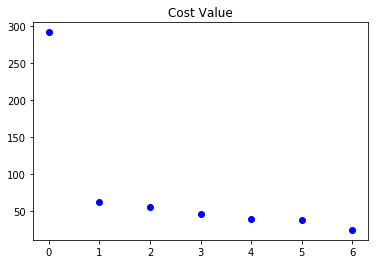

In [137]:
u,s,v = np.linalg.svd(X_std.T)
s
from matplotlib import pyplot as plt

k_array = []
cost_array = []
# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
for k in range(0,len(s)):
    cost_array.append(s[k])
    k_array.append(k)
print(cost_array)
print(k_array)
plt.scatter(k_array, cost_array, c = 'blue')
plt.title("Cost Value")
plt.show()

In [138]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
4.996250793262668
0.5374257495649637
0.466801631174978
0.3361796834781113
0.31170571498893546
0.2625250463856567
0.08911138114468903


In [139]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(7,1), 
                      eig_pairs[1][1].reshape(7,1)))

print('Matrix W:\n', matrix_w)



Matrix W:
 [[-3.34174683e-01  8.58621208e-01]
 [-4.15339418e-01 -2.79907633e-02]
 [-4.11925081e-01  3.33429610e-02]
 [-3.63994788e-01 -4.52951101e-01]
 [-3.63170195e-01 -1.70546171e-01]
 [-3.70492475e-01 -5.58945872e-04]
 [-3.80116701e-01 -1.63166715e-01]]
